In [1]:
import numpy as np
from torch import nn
import torch
import netCDF4
import util.ml_util as ut
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
jan_2020_data, jan_2020_target = ut.load_and_combine_data(2020, 'jan','dataset_1_closest_grid_cells', skip_bad_cells=True)
jan_2019_data, jan_2019_target = ut.load_and_combine_data(2019, 'jan','dataset_1_closest_grid_cells', skip_bad_cells=True)
jan_2021_data, jan_2021_target = ut.load_and_combine_data(2021, 'jan','dataset_1_closest_grid_cells', skip_bad_cells=True)
dec_2020_data, dec_2020_target = ut.load_and_combine_data(2020, 'dec','dataset_1_closest_grid_cells', skip_bad_cells=True)
sc = StandardScaler()
jan_2020_data = sc.fit_transform(jan_2020_data)
jan_2019_data = sc.fit_transform(jan_2019_data)
jan_2021_data = sc.fit_transform(jan_2021_data)
dec_2020_data = sc.fit_transform(dec_2020_data)
print(jan_2020_data.shape, jan_2019_data.shape, jan_2021_data.shape, dec_2020_data.shape)
#jan_2019_target +=1
#jan_2019_target = np.log(jan_2019_target)
#jan_2020_target +=1
#jan_2020_target = np.log(jan_2020_target)
#onzero_indices2019 = jan_2019_target[jan_2019_target ==1]
#zero_indices2020 = jan_2020_target[jan_2020_target ==0]


jan_2019_target = np.array([1 if i > 0  else 0 for i in jan_2019_target ])
jan_2020_target = np.array([1 if i > 0  else 0 for i in jan_2020_target ])
jan_2021_target = np.array([1 if i > 0  else 0 for i in jan_2021_target ])
dec_2020_target = np.array([1 if i > 0  else 0 for i in dec_2020_target ])

nonzero_data = jan_2019_data[jan_2019_target >0]
print(len(nonzero_data))
nonzero_targets = jan_2019_target[jan_2019_target >0]
for i in range(4):
    jan_2019_data = np.append(jan_2019_data, nonzero_data, axis = 0)
    jan_2019_target = np.append(jan_2019_target, nonzero_targets, axis = 0)

print(np.count_nonzero(jan_2020_target) /len(jan_2020_target))
print(np.count_nonzero(jan_2019_target)/len(jan_2019_target))

(8549, 14) (9245, 14) (7808, 14) (1413, 14)
1251
0.1244590010527547
0.4389781739069408


In [6]:
N = 14

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        #self.do = nn.Dropout(.3)
        self.fc4 = nn.Linear(64,32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        #x = self.fc5(x)
        return x

class simpleNet(nn.Module):
    def __init__(self, input_shape):
        super(simpleNet, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, input_shape)
        self.fc3 = nn.Linear(input_shape, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
#emperature = netCDF4.Dataset(ut.localize_nc_file('nor4km_data', 2021, 1, 5))['temperature'][12,0,:,:]
#print(temperature.shape)
#ut.print_on_map(temperature)
model = torch.load('pytorch_model')
pred = model(torch.tensor(jan_2021_data, dtype=torch.float32)).detach().numpy()
ut.validate(model,pred, jan_2021_target,.2 )

In [ ]:
XC_LOW = 41 #41
YC_LOW = 157 # 157
XC_HIGH = 671# 671
YC_HIGH = 373 #
model = torch.load('pytorch_model')
VARIABLES = ['temperature','salinity','u_east', 'v_north',  'w_north', 'w_east']
nc = netCDF4.Dataset(ut.localize_nc_file('nor4km_data',2021, 1,20 ))
data = ut.get_relevant_data_nc(nc,VARIABLES,12)
plankton = netCDF4.Dataset(ut.localize_plankton_file('plankton_data', 2021, 1, 20))['Calanus_finmarchicus']
#print(data.shape, plankton.shape)
data = np.append(data, plankton, axis=0)

grads = []
for i in range(len(VARIABLES) +1):
    grad = np.gradient(data[i,:,:])
    grad = np.sqrt(np.square(grad[0].data) + np.square(grad[0].data))
    grads.append(grad)
#print(data.shape, np.array(grads).shape)
data = np.append(data, grads, axis = 0)
#data = np.reshape(data, (-1,14))
#print(data.shape)
#prediction = model(torch.tensor(data,dtype=torch.float32)).detach().numpy()
#prediction = prediction.reshape(1,620,941)
pred = np.zeros((620, 941))
for xc in range(XC_LOW, XC_HIGH):
    if xc % 100 ==0: print(xc)
    for yc in range(YC_LOW, YC_HIGH):
        val = 1 if  model(torch.tensor(data[:,yc, xc],dtype=torch.float32)).detach().numpy()[0] > 0 else 0
        pred[yc, xc] =val
        #if val > 0:print(val)
print(np.count_nonzero(pred))
ut.print_on_map(pred)

In [ ]:
VARIABLES = ['temperature','salinity','u_east', 'v_north',  'w_north', 'w_east']
nc = netCDF4.Dataset(ut.localize_nc_file('nor4km_data',2021, 1,20 ))
data = ut.get_relevant_data_nc(nc,VARIABLES,12)
y, x =np.where(pred > .2)
mask = data[0,...].mask
print(mask)
masked = np.array([mask[y[i], x[i]] for i in range(len(y))])
print(np.count_nonzero(masked))

In [ ]:
learning_rate = .001
epochs = 300
model = Net(input_shape=jan_2019_data.shape[1])
#model = simpleNet(input_shape=jan_2019_data.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
#loss_fn = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(jan_2019_data,jan_2019_target)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [ ]:
losses = []
accur = []
valid_loss = []
valid_acc = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = model(x_train)
    #if j == 0:print(output)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(jan_2019_data,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == jan_2019_target).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%10 == 0:
    losses.append(loss)
    accur.append(acc)
    #print(y_train.shape, output.shape)
    output = model(torch.tensor(jan_2020_data,dtype=torch.float32))
    target = torch.tensor(jan_2020_target,dtype=torch.float32)
    _loss = loss_fn(output, target[:,None])
    _acc = (output.reshape(-1).detach().numpy().round() == jan_2020_target).mean()
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
    print("loss on test set: ", _loss, ' Acc on test set: ', _acc)
    valid_loss.append(_loss)
    valid_acc.append(_acc)

In [ ]:
#print(jan_2020_data)
#print(model(torch.tensor(jan_2020_data, dtype=torch.float32)))
predicted = model(torch.tensor(jan_2020_data,dtype=torch.float32))
acc = (predicted.reshape(-1).detach().numpy().round() == jan_2020_target).mean()
print(acc)
print(predicted.shape, torch.tensor(jan_2020_target.shape, dtype=torch.float32))
print(predicted)
loss = loss_fn(predicted.reshape(1,-1), torch.tensor(jan_2020_target.reshape(1,-1)))
print(loss)

In [ ]:
#plotting the loss
losses = [l.data for l in losses]
valid_loss = [l.data for l in valid_loss]
plt.plot([i*10 for i in range(30)], losses)
plt.plot([i*10 for i in range(30)],valid_loss )
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend(['training_set', 'validation_set'])

In [ ]:
#printing the accuracy
plt.plot( [i*10 for i in range(30)],accur)
plt.plot([i*10 for i in range(30)],valid_acc)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training_set', 'validation_set'])

In [ ]:
torch.save(model, 'pytorch_model_300_epochs')

In [ ]:
from sklearn import ensemble, metrics

In [ ]:
pred = model(torch.tensor(jan_2021_data, dtype=torch.float32)).detach().numpy()
pred = [1 if p > .2 else 0 for p in pred]
metrics.ConfusionMatrixDisplay.from_predictions(jan_2021_target,pred)

In [ ]:
pred = model(torch.tensor(jan_2021_data, dtype=torch.float32)).detach().numpy()
cutoffs = [.5 + .025*i for i in range(10)]
print(cutoffs)
pred =[ [1 if p > c else 0 for p in pred] for c in cutoffs]
acc = []
sens = []
spec = []
all_pos = np.count_nonzero(jan_2021_target)
for p in pred:
    true_pos = 0
    true_neg = 0
    pos = 0
    neg = 0
    acc.append(np.array([p == jan_2021_target]).mean())
    for i in range(len(p)):
        if jan_2021_target[i] == 1:
            if p[i] == 1: 
                true_pos += 1
                pos += 1
            else: neg += 1
        else :
            if p[i] == 1:
                pos += 1
            else:
                neg += 1
                true_neg += 1
   # positives = [_p == 1 for _p in p]
    #negatives = [_p == 0 for _p in p]
    #true_positives = [x == 1 for x in jan_2020_target]
    #true_negatives = [x == 0 for x in jan_2020_target]
    #_sens = np.array([1 if positives[i] == true_positives[i] else 0 for i in range(len(positives))]).mean()
    #_spec = np.array([1 if negatives[i] == true_negatives[i] else 0 for i in range(len(negatives))]).mean()
    sens.append(true_pos/all_pos)
    spec.append(true_neg/ (len(jan_2021_target) - all_pos))
#pred = [np.array([p == jan_2020_target]).mean() for p in pred]
#print(pred)
#print(accuracy)
print([.5 + .025*i for i in range(10)],sens)
print([.5 + .025*i for i in range(10)],spec)
print([.5 + .025*i for i in range(10)],acc)
plt.xlabel("probability cutoff")
#metrics.ConfusionMatrixDisplay.from_predictions(jan_2020_target,pred)

In [ ]:
plt.plot([.5 + .025*i for i in range(10)],sens)
plt.plot([.5 + .025*i for i in range(10)],spec)
plt.plot([.5 + .025*i for i in range(10)],acc)
plt.legend(['Sensitivity',' Specificity','Accuracy'])
plt.xlabel("Probability cutoff")

In [ ]:
model = ensemble.AdaBoostClassifier(n_estimators=1000, learning_rate = .001)
model.fit(jan_2019_data, jan_2019_target)
r_sq = model.score(jan_2019_data, jan_2019_target)
metrics.ConfusionMatrixDisplay.from_predictions(jan_2020_target,model.predict(jan_2020_data))


In [ ]:
torch.save(model, 'pytorch_model_5k_epochs')

In [3]:

import sklearn
import h2o
from h2o.automl import H2OAutoML
#h2o.shutdown()
h2o.init(log_level='FATA')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\Users\evenasm\Documents\sild_høst_2022\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\evenasm\AppData\Local\Temp\tmpn7gdz0jt
  JVM stdout: C:\Users\evenasm\AppData\Local\Temp\tmpn7gdz0jt\h2o_evenasm_started_from_python.out
  JVM stderr: C:\Users\evenasm\AppData\Local\Temp\tmpn7gdz0jt\h2o_evenasm_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_evenasm_1k84sy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.953 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [4]:
names = ['Temperature',  'Salinity', 'u_east', 'v_north',  'w_north', 'w_east','Temperature gradient', \
     'Salinity gradient','w_east_gradient', 'u_east gradient','v_north_gradient','w_north_gradient','Calanus finmarchicus', \
        'Calanus finmarchicus gradient', 'Catch']
x_vars =  ['Temperature',  'Salinity', 'u_east', 'v_north',  'w_north', 'w_east','Temperature gradient', \
     'Salinity gradient','w_east_gradient', 'u_east gradient','v_north_gradient','w_north_gradient','Calanus finmarchicus', \
        'Calanus finmarchicus gradient']
print(jan_2019_data.shape)
training = np.append(jan_2019_data, np.expand_dims(jan_2019_target,1), axis=1)
#training = np.append(dec_2020_data,np.expand_dims(dec_2020_target,1), axis=1)
valid = np.append(jan_2020_data, np.expand_dims(jan_2020_target,1), axis=1)
train = h2o.H2OFrame(training,column_names =names)
valid = h2o.H2OFrame(valid, column_names = names)
print(train.head())
train['Catch'] = train['Catch'].asfactor()
valid['Catch'] = valid['Catch'].asfactor()

jan_2021_data_aml = h2o.H2OFrame(np.append(jan_2021_data, np.expand_dims(jan_2021_target,1), axis=1), column_names = names)

(14249, 14)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  Temperature    Salinity     u_east    v_north     w_north     w_east    Temperature gradient    Salinity gradient    w_east_gradient    u_east gradient    v_north_gradient    w_north_gradient    Calanus finmarchicus    Calanus finmarchicus gradient    Catch
     0.601918  -0.899872   -0.103917  -0.397865   0.0160393  -0.868953                0.955403            -0.444607          -0.946055          -0.389327           0.15441              1.04333                -0.437786                        -0.460396        0
    -0.287215   0.0633507  -1.60068   -1.79198   -0.686677   -2.24817                 0.276672            -0.845797           2.2348             3.18703           -0.296081             1.14279                -0.437786                        -0.460396        0
    -0.77951    0.

In [5]:
aml= H2OAutoML(max_models=10, seed=1, balance_classes = True,nfolds = 0)
aml.train(x=x_vars, y='Catch',training_frame=train, validation_frame = valid)

AutoML progress: |
21:40:16.359: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_1_AutoML_1_20221206_214016


Status of Neuron Layers: predicting Catch, 2-class classification, bernoulli distribution, CrossEntropy loss, 392 weights/biases, 11,6 KB, 159 760 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms          mean_bias              bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  ------------------  ---------------------  --------------------
    1        14       Input      0.0
    2        10       Rectifier  0.0        0.0   0.0   0.0015740732745533543  0.001098331529647112   0.0         -0.021407113725477496  0.2832674980163574  0.5384258399640073     0.05137626826763153
    3        10       Rectifier  0.0        0.0   0.0   0.0008202048116072547  0.0006934700068086386  0.0         -0.00806643550604349   0.285007119178772   0.9751403574193368     0.0720674991607666
    4        10       Rectifier  0.0        0.0   0.0   0.0011376585878315382  0.001376246102154255   0.0         -0.007313026110641658  0.3820613622665405  0.9803806504469547     0.057230740785598755
    5        2        Softmax               0.0   0.0   0.00178802131122211    0.0015897806733846664  0.0         -0.24643079480156302   1.441141128540039   -0.003430342811709338  0.048927679657936096

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.288747536064739
RMSE: 0.5373523388473702
LogLoss: 0.801774061685663
Mean Per-Class Error: 0.3423315930760269
AUC: 0.7043013634050646
AUCPR: 0.6544900628047399
Gini: 0.4086027268101291

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09885491111619456
       0     1     Error    Rate
-----  ----  ----  -------  ----------------
0      1881  3139  0.6253   (3139.0/5020.0)
1      297   4706  0.0594   (297.0/5003.0)
Total  2178  7845  0.3428   (3436.0/10023.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0988549    0.732565  322
max f2                       0.0555998    0.857708  352
max f0point5                 0.199742     0.649887  249
max accuracy                 0.116211     0.660281  310
max precision                0.74687      1         0
max recall                   0.00230253   1         397
max specificity              0.74687      1         0
max absolute_mcc             0.0988549    0.382311  322
max min_per_class_accuracy   0.232663     0.639017  227
max mean_per_class_accuracy  0.116211     0.660706  310
max tns                      0.74687      5020      0
max fns                      0.74687      5001      0
max fps                      0.000566809  5020      399
max tps                      0.00230253   5003      397
max tnr                      0.74687      1         0
max fnr                      0.74687      0.9996    0
max fpr                      0.000566809  1         399
max tpr                      0.00230253   1         397

Gains/Lift Table: Avg response rate: 49,92 %, avg score: 23,81 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0101766                   0.602606           1.49273   1.49273            0.745098         0.650516   0.745098                    0.650516            0.0151909       0

In [ ]:
pred = aml.predict(jan_2021_data_aml).as_data_frame().to_numpy()
#pred = aml.predict(jan_2021_data_aml).as_data_frame().to_numpy()
#print(jan_2021_data_aml.head())
#print(len(pred['predict']))
#print(pred['predict'].shape)
#pred = np.reshape(np.array(pred['predict']), (1,-1))
#print(pred[pred > 0])
print(pred.shape)
pred = pred[:,0]
print(type(pred), pred)
ut.validate(aml, pred, jan_2021_target,.55)


In [14]:
XC_LOW = 41 #41
YC_LOW = 157 # 157
XC_HIGH = 671# 671
YC_HIGH = 373 #
#model = torch.load('pytorch_model')
VARIABLES = ['temperature','salinity','u_east', 'v_north',  'w_north', 'w_east']
nc = netCDF4.Dataset(ut.localize_nc_file('nor4km_data',2021, 1,20 ))
data = ut.get_relevant_data_nc(nc,VARIABLES,12)
plankton = netCDF4.Dataset(ut.localize_plankton_file('plankton_data', 2021, 1, 20))['Calanus_finmarchicus']
#print(data.shape, plankton.shape)
data = np.append(data, plankton, axis=0)
grads = []
for i in range(len(VARIABLES) +1):
    grad = np.gradient(data[i,:,:])
    grad = np.sqrt(np.square(grad[0].data) + np.square(grad[0].data))
    grads.append(grad)
#print(data.shape, np.array(grads).shape)
data = np.append(data, grads, axis = 0)
print(data.shape)
#data = np.reshape(data, (-1,14))
#print(data.shape)
#prediction = model(torch.tensor(data,dtype=torch.float32)).detach().numpy()
#prediction = prediction.reshape(1,620,941)
pred = np.zeros((620, 941,3))
pred = np.array( [aml.predict(h2o.H2OFrame(data[:,i,:].T, column_names = names)).as_data_frame().to_numpy()[:,:] for i in range(620)])

prediction_data = []
#[[prediction_data.append(data[:,yc, xc]) for yc in range(YC_LOW, YC_HIGH)]for xc in range(XC_LOW, XC_HIGH)]
prediction_data = np.array(prediction_data)
prediction_data= aml.predict(h2o.H2OFrame(prediction_data, column_names = names))
i = 0
prediction_data = prediction_data.as_data_frame().to_numpy()
#[[pred[i,j] = model(torch.tensor(data[:,i,j],

(14, 620, 941)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Parse progress: |██████████████████

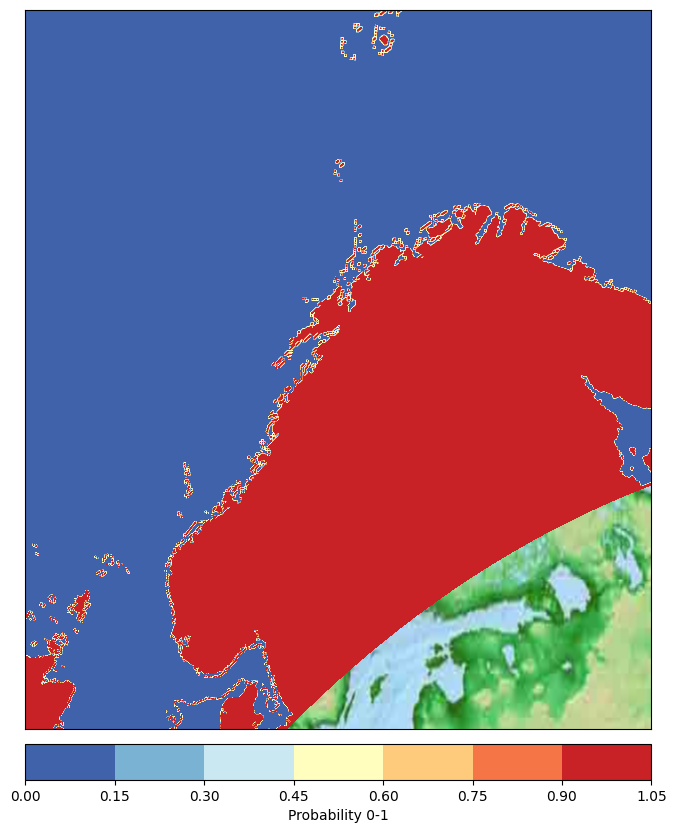

In [17]:
#np.save('pred', pred)
pred = np.load('pred.npy')
ut.print_on_map(pred[...,1])


(array([[472.,   0.,   0., ...,   0.,   0., 148.],
        [477.,   0.,   0., ...,   0.,   0., 143.],
        [473.,   0.,   0., ...,   0.,   0., 147.],
        ...,
        [438.,   0.,   0., ...,   0.,   0., 182.],
        [435.,   0.,   0., ...,   0.,   0., 185.],
        [432.,   0.,   0., ...,   0.,   0., 188.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 941 BarContainer objects>)

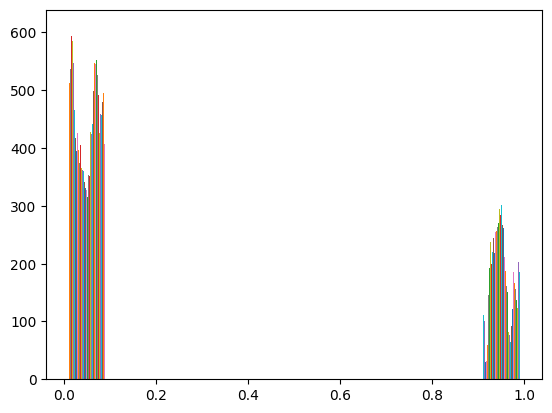

In [13]:
plt.hist(pred)

In [19]:
i = 0

for xc in range(XC_LOW, XC_HIGH):
    if xc % 100 ==0: print(xc)
    for yc in range(YC_LOW, YC_HIGH):
        data = prediction_data[i]
        #print(data)
        pred[yc, xc] = prediction_data[i,0]

100
200
300
400
500
600


429584


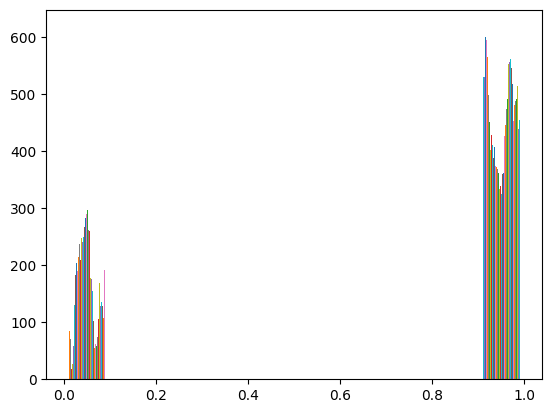

In [190]:
plt.hist(_pred)
print(np.count_nonzero(_pred > .5))

In [171]:
#data = ut.get_relevant_data_nc(nc,VARIABLES,12)
#mask = data[0,...].mask
data = h2o.H2OFrame(np.reshape(data, (-1,14)), column_names = names)
pred = aml.predict(data).as_data_frame().to_numpy()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


(583420, 3)


In [149]:
_pred = pred[:,1]
_pred = np.reshape(_pred,(-1,1))
print(_pred.shape)
_pred = np.reshape(_pred, (620, 941),order='A')


(583420, 1)


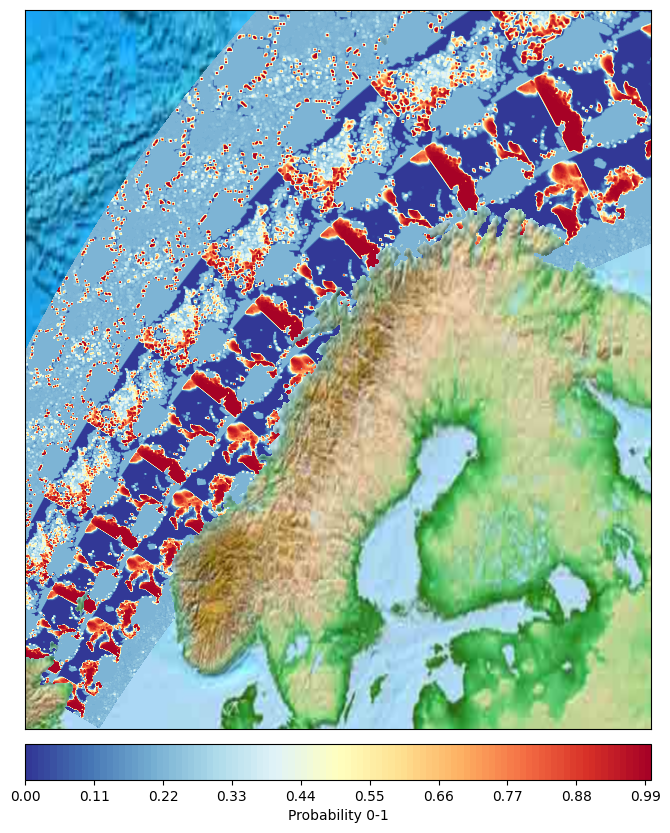

In [150]:
ut.print_on_map(_pred[...])

(620, 941)
(583420, 15)
(1, 583420)
(1, 583420)


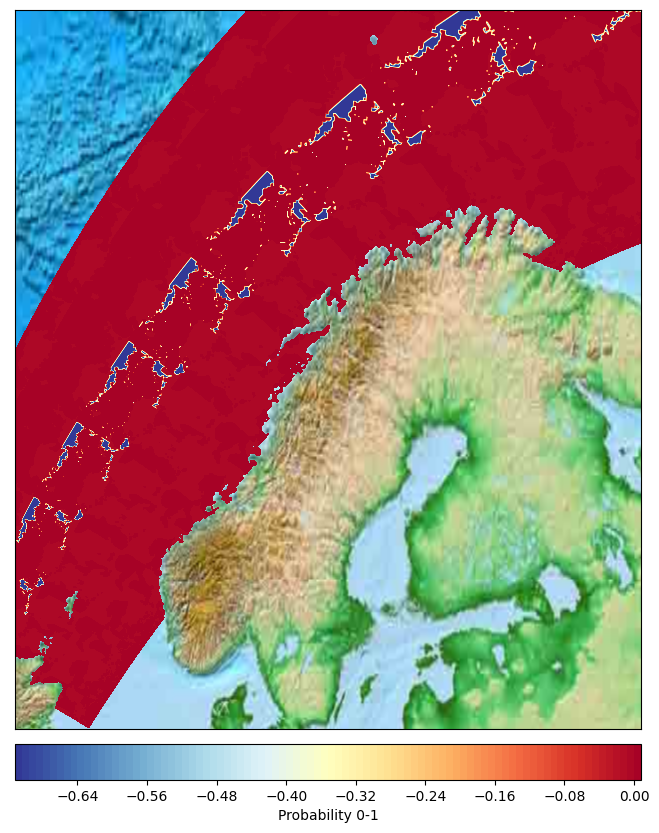

In [179]:
d = ut.get_relevant_data_nc(nc,VARIABLES,12)
temp = data['Temperature'].as_data_frame().to_numpy()
print(d[0,...].shape)
#print(temp.flags, d.flags)
#print(temp.shape, d[0,...].shape)
#d_temp = np.reshape(d[0,...],(-1,1))
##temp = np.reshape(temp,(620,941))
#print(type(temp), temp.shape)
#print(type(d_temp))
#liste = np.zeros((620,941))
#for i in range(1,941):
#    liste[:,i] = temp[620*(i-1):(620*i)][:,0]
#_temp = np.array(liste)
#print(liste.shape)
print(data.shape)

temp = np.reshape(temp, (1,-1))
print(temp.shape)
#l = []
#for i in range(620):
 #   l.append(temp[941*i:941*(i+1)])
#temp = np.array(l)
print(temp.shape)
temp = np.reshape(temp,(1,620,941))
#_temp = np.reshape(temp, (620,941),order='C')
#_d_temp = np.reshape(d_temp,(620,941),order='F')
ut.print_on_map(temp[0,...])